In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, multivariate_normal
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

from densratio import densratio
from numpy import linalg as la
import matplotlib.pyplot as plt
from densratio import densratio

# Functions

In [541]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Lasso

    

def density_ratio_estimate_prob_RF(D_nu, D_de, n_estimators=100):
    l_nu = np.ones(len(D_nu))
    l_de = np.zeros(len(D_de))
    
    l = np.concatenate((l_nu, l_de))
    D = np.concatenate((D_nu, D_de))
    
    # Fit Random Forest model
    model = RandomForestClassifier()
    model.fit(D, l)
    
    # Get density ratios for all samples
    density_ratios = (model.predict_proba(D_de)[:, 1] / model.predict_proba(D_de)[:, 0]) * (len(D_de) / len(D_nu))
    
    return density_ratios


def density_ratio_estimate_prob_NN(D_nu, D_de, hidden_layer_sizes=(100,), cv=2):
    l_nu = np.ones(len(D_nu))
    l_de = np.zeros(len(D_de))
    
    l = np.concatenate((l_nu, l_de))
    D = np.concatenate((D_nu, D_de))
    
    # Fit neural network model with cross-validation
    model = MLPClassifier(activation= 'tanh',hidden_layer_sizes = hidden_layer_sizes)
    model.fit(D,l)
    
    # Get density ratios for all samples
    density_ratios = (model.predict_proba(D_de)[:, 1] / model.predict_proba(D_de)[:, 0]) * (len(D_de) / len(D_nu))
    
    return density_ratios

from sklearn.linear_model import LogisticRegressionCV

def density_ratio_estimate_prob_LR(D_nu, D_de, true_density = None,Z_known = True):
    if Z_known == False:
        l_nu = np.ones(len(D_nu))
        l_de = np.zeros(len(D_de))

        l = np.concatenate((l_nu, l_de))
        D = np.concatenate((D_nu, D_de))

        # Adding cross terms
        cross_terms_de = []
        n_covariates = D_de.shape[1]
        for i in range(n_covariates):
            for j in range(i, n_covariates):
                cross_term = D_de[:, i] * D_de[:, j]
                cross_terms_de.append(cross_term)
        cross_terms_de = np.array(cross_terms_de).T

        cross_terms_nu = []
        n_covariates = D_nu.shape[1]
        for i in range(n_covariates):
            for j in range(i , n_covariates):
                cross_term = D_nu[:, i] * D_nu[:, j]
                cross_terms_nu.append(cross_term)
        cross_terms_nu = np.array(cross_terms_nu).T


        D_nu_with_cross_terms = np.concatenate((D_nu, cross_terms_nu),axis = 1)
        D_de_with_cross_terms = np.concatenate((D_de, cross_terms_de), axis = 1)
        D_with_cross_terms = np.concatenate((D_nu_with_cross_terms, D_de_with_cross_terms))

        # Fit logistic model with cross terms
        C = 0.1
        model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5)
        model.fit(D_with_cross_terms, l)

        # Get density ratios for samples in D_de
        density_ratios = (model.predict_proba(D_de_with_cross_terms)[:, 1] / model.predict_proba(D_de_with_cross_terms)[:, 0]) * (len(D_de) / len(D_nu))
        
    if Z_known == True:
        l_nu = np.ones(len(D_nu))
        l_de = np.zeros(len(D_de))

        l = np.concatenate((l_nu, l_de))
        D = np.concatenate((D_nu, D_de))

        # Fit logistic model with cross terms

        model = LogisticRegressionCV(penalty='l2', cv = 2)
        model.fit(D, l)
        print(model.predict_proba(D_de)[:, 1])
        # Get density ratios for samples in D_de
        v_density_ratios = (model.predict_proba(D_de)[:, 1] / model.predict_proba(D_de)[:, 0]) * (len(D_de) / len(D_nu))
        density_ratios = v_density_ratios * np.array(true_density)
    return density_ratios




# def density_ratio_estimate_prob_KLR(D_nu, D_de, gamma=1.0):
#     l_nu = np.ones(len(D_nu))
#     l_de = np.zeros(len(D_de))

#     l = np.concatenate((l_nu, l_de))
#     D = np.concatenate((D_nu, D_de))

#     # Feature mapping using Gaussian RBF kernel approximation
#     feature_map = RBFSampler(gamma='scale', n_components=200)
#     X_mapped = feature_map.fit_transform(D)

#     # Fit kernel logistic model
#     model = LogisticRegressionCV(penalty='l1', solver='liblinear')
#     model.fit(X_mapped, l)

#     # Map test data to the feature space
#     D_de_mapped = feature_map.transform(D_de)

#     # Get density ratios for all samples
#     density_ratios = (model.predict_proba(D_de_mapped)[:, 1] / model.predict_proba(D_de_mapped)[:, 0]) * (len(D_de) / len(D_nu))

#     return density_ratios

  

def norm_est_ratio(D_s, D_t):
    ns = D_s.shape[0]
    nt = D_t.shape[0]
    p = D_s.shape[1]
    
    ED_s = np.mean(D_s, axis=0)
    ED_t = np.mean(D_t, axis=0)
    
    CS = np.cov(D_s.T)
    CT = np.cov(D_t.T)
    
    pdf_s = multivariate_normal.pdf(D_s, mean=ED_s, cov=CS)
    pdf_t = multivariate_normal.pdf(D_s, mean=ED_t, cov=CT)
    
    true_ = pdf_t / pdf_s
    
    return true_

    


# def Covariate_Shift_Weight(x, z, v = 0):
#     return np.exp(((x - z @ s)**2 - (x - z @ t)**2)/2)

def Model_X(z, v, u):
    return z[:5] @ u + np.random.normal(0, 1, 1)

## group samples together

def T_statistic(y, x, z, v, u,s, t,regr):
#     d_y = regr.predict(z.reshape(1, z.shape[0]))
#     # d_y = (1+s)@z
#     d_x = z[:5]@u
    
#     return np.abs(((y-d_y)*(x-d_x)))
    return (y - z.sum()- x)**2
    # return coef[0]

def Conterfeits(y, x, z, v, u,s, t, L, K, regr):
    M = L * K - 1
    cnt = 0
    t_stat = T_statistic(y, x, z, v, u,s, t,regr)

    for i in range(M):
        x_ = Model_X(z, v, u)
        if t_stat > T_statistic(y, x_, z, v, u,s, t, regr):
            cnt=cnt+1
            
    return cnt // K

def PCRtest( Y, X, Z, V, u, s, t, L, K, covariate_shift, density_ratio, regr):
    n = Y.size
    W = np.array([0.0]*L)

    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        if covariate_shift == True:
            ind = Conterfeits(y, x, z, v, u,s, t, L, K, regr)
            if true_density == False:
                W[ind] += density_ratio[j]
                
        if covariate_shift == False:
            W[Conterfeits(y, x, z, v, u,s, t, L, K, regr)] += 1
    return W, L/n * np.dot(W - n/L, W - n/L)

def generate_cov_matrix(Y, X, Z, V,u, s, t, L, K, density_ratio, regr):
    """
    Generate a covariance matrix for quadratic form normal rv.

    Parameters:
    - L (int): The size of the covariance matrix.

    Returns:
    - covariance_matrix (ndarray): The generated covariance matrix.
    """
    n = Y.size
    diag = np.array([0.0]*L)
    
    for j in range(n):
        y, x, z, v = Y[j], X[j], Z[j], V[j]
        if true_density == False:
            diag[Conterfeits(y, x, z, v, u,s,t,L, K, regr)] += (density_ratio[j]**2)
    diag = L*(diag/n)- 1/L
    covariance_matrix = np.full((L, L), -1/L)  # Fill all entries with 1/L
    np.fill_diagonal(covariance_matrix, diag)  # Set diagonal entries to 1 - 1/L^2
    return covariance_matrix
    

In [527]:
#get p values

import scipy.stats as stats

def chi_squared_p_value(chi_squared_statistic, df):
    """
    Calculate the p-value from a chi-squared distribution.

    Parameters:
    - chi_squared_statistic (float): The observed chi-squared test statistic.
    - df (int): The degrees of freedom.

    Returns:
    - p_value (float): The calculated p-value.
    """
    p_value = 1 - stats.chi2.cdf(chi_squared_statistic, df)
    return p_value

def monte_carlo_p_value(n_samples, covariance_matrix, L, quantile):
    """
    Calculate the probability corresponding to a given quantile using the Monte Carlo method.

    Parameters:
    - n_samples (int): The number of Monte Carlo samples to generate.
    - covariance_matrix (ndarray): The covariance matrix of the random vector X.
    - L (int): The number of components to sum.
    - quantile (float): The quantile value.

    Returns:
    - probability (float): The estimated probability corresponding to the quantile.
    """
    count = 0
    for _ in range(n_samples):
        sample = np.random.multivariate_normal(np.zeros(L), covariance_matrix)
        squared_sum = np.sum(sample**2)
        if squared_sum <= quantile:
            count += 1

    probability = count / n_samples
    return 1-probability


# 生成数据

In [669]:
# Generate Data


import numpy as np

def generate(ns, nt, p,q, s, t, u, Alpha=0):
    Zs_null = np.random.normal(0,0.1, (ns, q))
    Zt_null = np.random.normal(0,0.1, (nt, q))
    
    Z_source = np.hstack((np.random.normal(2, 1, (ns, p)) , Zs_null))
    Z_target = np.hstack((np.random.normal(0, 1, (nt, p)) , Zt_null))
    
    X_source = Z_source[:, :p] @ u + np.random.normal(0, 1, ns)
    X_target = Z_target[:, :p] @ u + np.random.normal(0, 1, nt)

    V_source = Z_source[:, :p] @ s + 2*X_source + np.random.normal(0, 1, ns)
    V_target = Z_target[:, :p] @ t - 2*X_target + np.random.normal(0, 1, nt)
    
    # V_source = Z_source[:, :p] @ s + 2*X_source 
    # V_target = Z_target[:, :p] @ t - 2*X_target
    
    Y_source = (Z_source[:, :p].sum(axis=1))**2 + 2*X_source + V_source + np.random.normal(0, 1, ns) + Alpha * X_source
    Y_target = (Z_target[:, :p].sum(axis=1))**2 + 2*X_target + V_target + np.random.normal(0, 1, nt) + Alpha * X_target
    
    
    return Y_source.reshape(-1, 1), X_source.reshape(-1, 1), V_source.reshape(-1, 1), Z_source,\
           Y_target.reshape(-1, 1), X_target.reshape(-1, 1), V_target.reshape(-1, 1), Z_target


def true_density_ratio(X, Z, V, s, t,p,q):
    ratios = []
    for i in range(2000):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        vs_prob = norm.pdf(V[i], loc=Z[i][:p]@s + 2*X[i], scale =1)
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = 2*np.ones(p), cov= 1*np.identity(p))
        vt_prob = norm.pdf(V[i], loc=Z[i][:p]@t - 2*X[i], scale =1)
        ratios.append((zt_prob*vt_prob)/(zs_prob*vs_prob))
    # zs_probs = multivariate_normal.pdf(Z[:, :p], mean=0*np.ones(p), cov=np.identity(p))
    # vs_probs = norm.pdf(V, loc=(Z[:, :p] @ s).reshape(-1,1) + 2*X, scale=5)
    # zt_probs = multivariate_normal.pdf(Z[:, :p], mean=0.2*np.ones(p), cov=np.identity(p))
    # vt_probs = norm.pdf(V, loc=(Z[:, :p] @ t).reshape(-1,1) - 2*X, scale=5)
    # ratios = (zt_probs * vt_probs) / (zs_probs * vs_probs)
    return ratios

def xz_ratio(X, Z, V, s, t,p,q):
    ratios = []
    for i in range(2000):
        zs_prob = multivariate_normal.pdf(Z[i][:p], mean = 0*np.ones(p), cov= 1*np.identity(p))
        zt_prob = multivariate_normal.pdf(Z[i][:p], mean = 2*np.ones(p), cov= 1*np.identity(p))
        ratios.append((zt_prob)/(zs_prob))
    
    return ratios
    # return np.exp(0.5*Z.sum() - 0.25*(1/2) - (1/200)*(V- t@Z +X)**2 + (1/200)*(V - s@Z - X)**2)

# Test procedure

In [670]:
# 
ns,nt, p,q = 2000,5000, 5, 5
s = np.random.normal(1, 1, p)
t = np.random.normal(0, 1, p)
u = np.random.normal(2, 1, p)
# t = s + 4*u

In [671]:
#generate data
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0)

# calculate density ratio
D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

# densratio_obj = densratio(D_t, D_s)
reg=1

true_dr = true_density_ratio(X_source,Z_source, V_source, s,t,p,q)
# xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
# sample_density_ratio2 = norm_est_ratio(D_s, D_t) * xz_dr
xz_dr = xz_ratio(X_source,Z_source, V_source, s,t,p,q)
sample_density_ratio2 = density_ratio_estimate_prob_LR(V_target, V_source, true_density= xz_dr, Z_known= True)


[1.03090111e-02 8.13173249e-04 5.17790365e-02 ... 5.24689794e-01
 4.10100002e-01 9.88407029e-01]


In [389]:
# reg = LassoCV().fit(Z_source,Y_source.ravel())
# print(reg.coef_)
PCRtest(Y_source, X_source, Z_source,V_source,u,s,t, L = 5, K = 20, covariate_shift = False, density_ratio = sample_density_ratio2, regr = reg)

(array([503., 484., 395., 344., 274.]), 91.755)

In [234]:
# reg = LassoCV().fit(Z_target,Y_target.ravel())
PCRtest(Y_target, X_target, Z_target,V_target,u,s,t, L = 5, K = 20, covariate_shift = False, density_ratio = sample_density_ratio2, regr = reg)

(array([ 989., 1016., 1025.,  953., 1017.]), 3.5)

In [672]:
print(np.max(true_dr))
print(np.min(true_dr))
mean = np.mean(true_dr)
print(mean)

0.06325306455409861
0.0
0.00011850671630284597


In [673]:
print(np.max(sample_density_ratio2))
print(np.min(sample_density_ratio2))
mean = np.mean(sample_density_ratio2)
print(mean)
# sample_density_ratio2 = sample_density_ratio2/mean

0.01897748209430317
1.6367889997957233e-11
0.00010247158083705735


4.486262901139303e-06


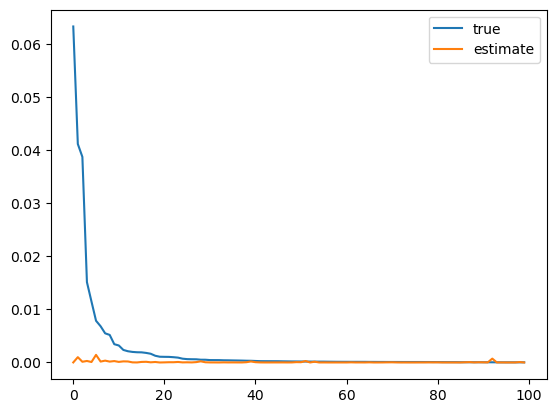

In [675]:
import matplotlib.pyplot as plt


# Sort the true_list in descending order
combined_lists = zip(true_dr, sample_density_ratio2)

# Sort the combined_lists based on the values of true_lst
sorted_combined_lists = sorted(combined_lists, key=lambda x: x[0],reverse=True)

# Separate the sorted lists back into true_lst and other_lst
sorted_true, sorted_estimate = zip(*sorted_combined_lists)

# Generate x-axis values
x_start = 0
x_end = 100
x = range(x_end - x_start)

# Calculate the difference between the true and estimate lists
difference = [true - estimate for true, estimate in zip(sorted_true, sorted_estimate)]

# # Create the plot for the difference
# plt.plot(x, difference[x_start:x_end], label='difference')

# # Add labels, title, and legend
# plt.xlabel('X')
# plt.ylabel('Difference')
# plt.title('Difference between true and estimate')
# plt.legend()

# # Show the plot
# plt.show()
print(la.norm(difference)**2/2000)
# plt.plot(x, true_list[x_start:x_end], label='true')
# plt.plot(x, sample_density_ratio2[x_start:x_end], label='estimate')
plt.plot(x, sorted_true[x_start:x_end], label='true')
plt.plot(x, sorted_estimate[x_start:x_end], label='estimate')
plt.legend()
plt.show()

In [87]:
# Calculate average loss of 2 estimate method
for i in range(1000):
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0)

    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)



5.516748927860167

## Test

In [292]:
# verificaion by the p value
l = 5
count = 0
#calculate covariance matrix

for j in trange(400):
    #generate data
    Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0)

    # calculate density ratio
    D_s = np.concatenate((X_source, Z_source, V_source), axis = 1)
    D_t = np.concatenate((X_target, Z_target, V_target), axis = 1)

    
    # densratio_obj = densratio(D_t, D_s)
    # #calculate density ratio for each sample
    # sample_density_ratio1 = densratio_obj.compute_density_ratio(D_s)

    # sample_density_ratio2 = density_ratio_estimate_prob_LR(D_t, D_s)
    # reg = LassoCV().fit(Z_source,Y_source.ravel())
    
    # z_ratio = density_ratio_estimate_prob_LR(Z_target[:,:p],Z_source[:,:p])
    # v_ratio = density_ratio_estimate_prob_LR(V_target,V_source)
    sample_density_ratio2 = density_ratio_estimate_prob_LR(D_t, D_s)
    # sample_density_ratio2 = norm_est_ratio(D_s, D_t)
    
    cov1 = generate_cov_matrix(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, density_ratio = sample_density_ratio2, regr = reg,true_density = False)
    w, statistic = PCRtest(Y_source[:2000], X_source[:2000], Z_source[:2000],V_source[:2000],u,s,t, L = l, K = 20, covariate_shift = True, density_ratio = sample_density_ratio2, regr = reg,true_density = False)
    print([w,statistic])
    p_value = monte_carlo_p_value(100000, cov1, l, statistic)
    print(p_value)
    if p_value < 0.1:
        count += 1
probability = count/400


  0%|          | 0/400 [00:00<?, ?it/s]

[array([361.85409439, 354.70963895, 420.92253317, 401.51599682,
       429.03605151]), 11.973674618278942]


  0%|          | 1/400 [00:22<2:30:52, 22.69s/it]

0.10089999999999999
[array([378.18127866, 360.28862612, 417.61217696, 406.22032578,
       464.95939588]), 16.554135399191118]


  0%|          | 2/400 [00:45<2:32:48, 23.04s/it]

0.05242999999999998
[array([337.18116649, 357.34638191, 401.04273425, 481.9193595 ,
       455.11294041]), 38.78710484126609]


  1%|          | 3/400 [01:11<2:38:48, 24.00s/it]

0.0013499999999999623
[array([372.48650473, 343.04949438, 391.71857613, 466.94713397,
       431.51484177]), 23.86009622955541]


  1%|          | 4/400 [01:36<2:40:57, 24.39s/it]

0.022179999999999978


  1%|          | 4/400 [01:38<2:43:11, 24.73s/it]


KeyboardInterrupt: 

In [50]:
probability

0.05333333333333334

In [ ]:
def multiple_test():

In [ ]:
# previous code

# def int_(x):
#     if x >= 80: return 79
#     return int(x)

# def Many_Tests(m, Alpha):
#     X = []
#     n, p=500, 20
#     for i in trange(m):
#         s = np.random.normal(0, 1, p)
#         t = s + np.random.normal(0, 0.1, p)
#         u = np.random.normal(0, 1, p)
#         Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(n, p, s, t, u, Alpha)
#         u, v = PCRtest(Y_source, X_source, Z_source, L = 5, K = 20, covariate_shift = False)
#         X.append(v)
#     return X
# def Density_Variance(n):
#     a, b=0, 0
#     for i in range(n):
#         z = np.random.normal(0, 1, p)
#         x = z @ s + np.random.normal(0, 1, 1)
#         a += Covariate_Shift_Weight(x, z)**2
#         b += np.exp((z @ t - z @ s)**2)
#     return a/n, b/n

# Power simulation

1.First, we set the rejection threshold to be 0.05. We will run 1000 simulations to estimate the power and average the results over 1000 trials. Plot the power w.r.t L with fixed K = 50.

In [ ]:
# simulation code
K = 20
L = 10
n, p = 1000, 20
s = np.random.normal(0, 1, p)
t = s + np.random.normal(0, 0.1, p)
u = np.random.normal(0, 1, p)

result = []
for l in range(4, 30):
    for i in range
    cov1 = generate_cov_matrix(Y_source, X_source, Z_source, L = l, K = 20)
    result.append(monte_carlo_p_value(100000, cov1, l, PCRtest(Y_source, X_source, Z_source, L = l, K = 20, covariate_shift = True)[1]))
    
    

In [303]:
x = np.random.normal(0,25,500)
y = np.random.normal(2,1,500)
sum = 0
for i in range(500):
    sum += norm.pdf(x[i], loc = 5, scale = 25)/norm.pdf(x[i], loc = 0, scale = 25)
sum/500

1.0139707729582619

# Comparison with resampling method


In [274]:
def resample(Y_source, X_source, Z_source, V_source, M, true_density = True,density_ratio = None):
    n = Y_source.shape[0]
    Y_, X_, Z_, V_ = [], [], [], []
    if true_density:
        for i in range(n):
            value = true_density_ratio(X_source[i], Z_source[i], V_source[i], s, t, p,q)
            u = np.random.random()
            if value >= u * M:
                Y_.append(Y_source[i])
                X_.append(X_source[i])
                Z_.append(Z_source[i])
                V_.append(V_source[i])
    else:
        for i in range(n):
            value = density_ratio[i]
            u = np.random.random()
            if value >= u * M:
                Y_.append(Y_source[i])
                X_.append(X_source[i])
                Z_.append(Z_source[i])
                V_.append(V_source[i])
    Y_, X_, Z_, V_ = np.array(Y_) , np.array(X_), np.array(Z_), np.array(V_)
    return Y_, X_, Z_, V_

In [275]:
Y_source, X_source, V_source, Z_source, Y_target, X_target, V_target, Z_target = generate(ns,nt, p,q, s, t, u, 0)

sample_density_ratio2 = norm_est_ratio(D_s, D_t)
# sample_density_ratio2 = density_ratio_estimate_prob_LR(D_t, D_s)

sum = 0
max = 0
min = np.inf
true_list = []
for i in range(1000):
    value = true_density_ratio(X_source[i], Z_source[i], V_source[i], s, t, p,q)
    true_list.append(value)
    if value <= min:
        min = value
    elif value >= max:
        max = value
    sum += value
    # print(true_density_ratio(X_source[i], Z_source[i], V_source[i], s, t))
    # print(Z_source[i]@s + X_source[i] - Z_source[i]@t + X_source[i])
print(sum/2000)
print(max)
print(min)

[0.48769668]
[12.77072411]
[0.00167716]


In [276]:
Y_, X_, Z_, V_ = resample(Y_source, X_source, Z_source, V_source, max,true_density=False, density_ratio=sample_density_ratio2)
PCRtest(Y_, X_, Z_, V_, u, s, t, L = 5, K = 20, covariate_shift = False, density_ratio = sample_density_ratio2, regr = reg)

(array([13., 16., 18., 21., 15.]), 2.240963855421687)

In [277]:
Y_.shape

(83, 1)

# 6. Function testing code

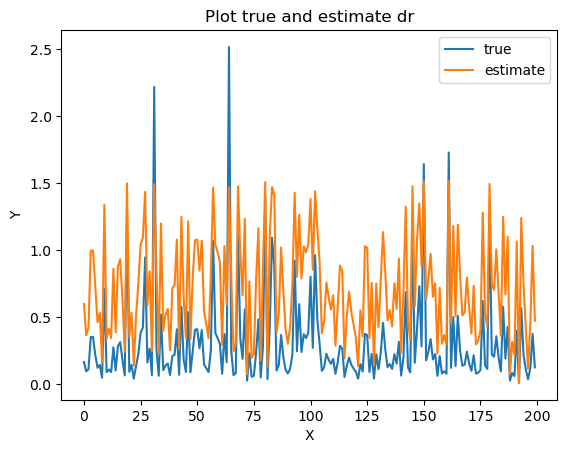

In [660]:
# Test density ratio estimation
nn = 200

o = np.random.normal(1, 1, (nn,1))
a = np.random.normal(2, 1, (nn,1))
d = density_ratio_estimate_prob_LR(o,a,Z_known=False)

true = []
for i in a:
    true.append(np.exp(1/2 - i.sum()))

import matplotlib.pyplot as plt


# Generate x-axis values
x = range(nn)

# Create the plot with two lines
plt.plot(x, true, label='true')
plt.plot(x, d, label='estimate')

# Add labels, title, and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot true and estimate dr')
plt.legend()

# Show the plot
plt.show()
